# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


#### Import modules

In [1]:
import pickle
import numpy as np
import numpy.random as rand
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
from sklearn.utils import shuffle
# import random as rd
import tensorflow as tf
from sklearn.utils import shuffle
import pandas as pd
import datetime
import os

#### Create mapping dictionary from csv file

In [3]:
import csv

map_ids = []
with open('signnames.csv', 'r') as map_file:
    reader = csv.reader(map_file, delimiter=',')
    next(reader,None)
    for row in reader:
        map_ids.append(row[1])

---
## Step 0: Load The Data

The provided data is already devided into training, validation and test set. First the different data sets are loaded into workspace.

In [4]:
import pickle

training_file = "../traffic-signs-data/train.p"
validation_file = "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

The data sets all consist of a dictionary with 4 key/value pairs:

* `features`: A 4D array containing all the RGB images (# of images, width, height, color channels).
* `labels`: A 1D array containing the class ids for each traffic sign. The provided file `signnames.csv` contains a mapping from the class ids to the label names of the included signs.
* `sizes`: A list of tuples containing the widths and heights of the original images.
* `coords`: A list of tuples containing the coordinates of bounding boxes around the signs in the original images.

In this project only `features` and `labels` are used. `sizes` and `coords` are not needed.

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
import numpy as np

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_test.shape[1:]
n_classes = np.max(y_test)+1

print('{:<30}{:^5}{:<10}'.format('Number of training examples', '=', n_train))
print('{:<30}{:^5}{:<10}'.format('Number of validation examples', '=', n_valid))
print('{:<30}{:^5}{:<10}'.format('Number of testing examples', '=', n_test))
print('{:<30}{:^5}{:<10}'.format('Image shape', '=', 
                                 str(image_shape[0])+'x'+str(image_shape[1])+'x'+str(image_shape[2])))
print('{:<30}{:^5}{:<10}'.format('Number of classes', '=', n_classes))

Number of training examples     =  34799     
Number of validation examples   =  4410      
Number of testing examples      =  12630     
Image shape                     =  32x32x3   
Number of classes               =  43        


### Include an exploratory visualization of the dataset

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
explore_data = True

#### Plot example images of each class

In [9]:
def plot_all(X_data, y_data, n_rows=n_classes, n_cols=5):
    '''Function plots example images of all classes. n_rows specifies the number of classes shown, 
    n_cols the number of images per class.'''
    number_of_images = n_rows*n_cols
    figure, axis = plt.subplots(n_rows, n_cols+1, figsize=(5, 43))

    for i_row in range(n_rows):
        idx_spc = np.where(y_data==i_row)
        for i_col in range(n_cols):
            idx = np.random.randint(idx_spc[0][0],idx_spc[0][-1])
            image = X_data[idx,:,:,:]
            axis[i_row,i_col].axis('off')
            axis[i_row,i_col].imshow(image)
            if i_col==n_cols-1:
                axis[i_row,i_col+1].axis('off')
                axis[i_row,i_col+1].text(.5,.5,map_ids[i_row],ha='left')

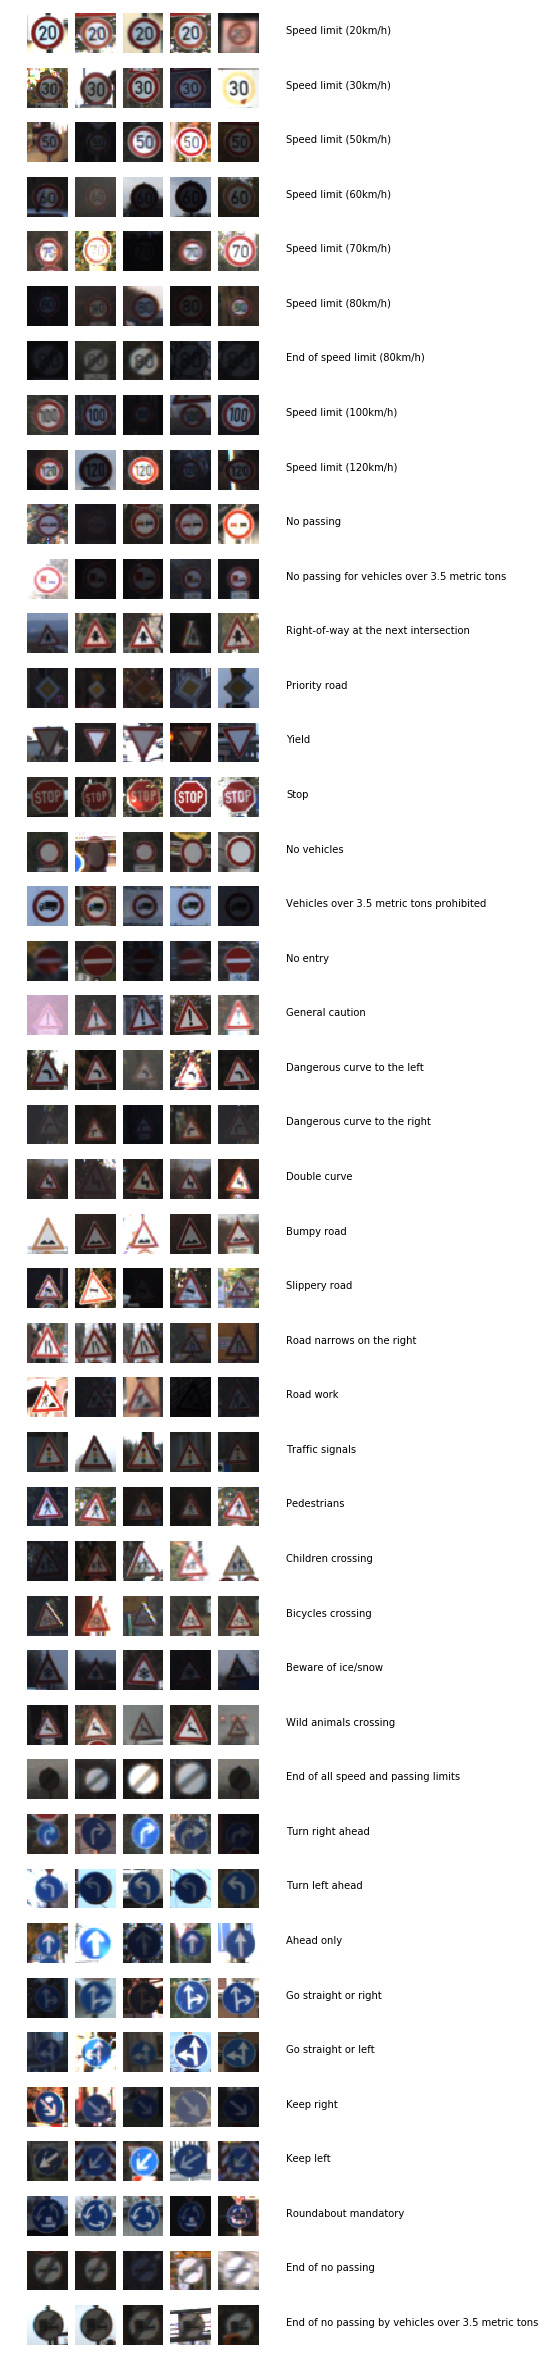

In [10]:
if explore_data:
    plot_all(X_train, y_train)

#### Plot dataset class distributions

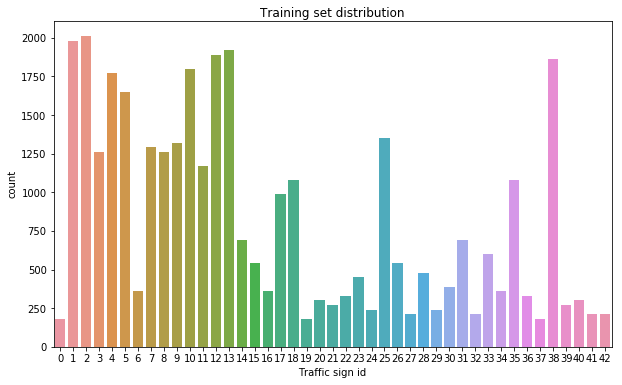

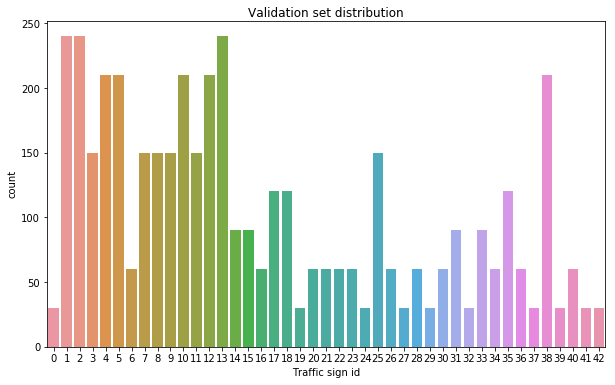

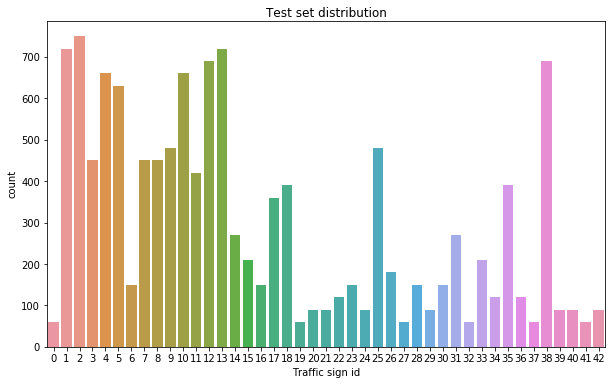

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(10,6))
p = sns.countplot(y_train)
plt.title('Training set distribution')
plt.xlabel('Traffic sign id')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.countplot(y_valid)
plt.title('Validation set distribution')
plt.xlabel('Traffic sign id')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.countplot(y_test)
plt.title('Test set distribution')
plt.xlabel('Traffic sign id')
plt.show()

#### Balance class distributions

The unbalanced class distributions are balanced by simply copying the existing images.

In [13]:
class_id, class_size = np.unique(y_train, return_counts=True)
max_class_size = np.max(class_size)

# set target class size
target_class_size = 3000

X_train_bal = np.zeros((n_classes*target_class_size,32,32,3),dtype=np.uint8)
y_train_bal = np.zeros((n_classes*target_class_size),dtype=int)

start = 0
for i in range(n_classes):

    # get all images and labels of the current class i
    X_train_class = X_train[np.where(y_train==i)]
    y_train_class = y_train[np.where(y_train==i)]

    # 'prop' indicates how often the initial number of images fits into the new class
    # 'rest' indicates the remaining number of images
    prop = target_class_size/class_size[i]
    rest = target_class_size%class_size[i]
    
    # if existing data fits more than once in new class
    if prop>1:
        # fill up with integer multiple
        X_train_bal[start:start+class_size[i]*int(prop)] = np.tile(X_train_class,(int(prop),1,1,1))
        y_train_bal[start:start+class_size[i]*int(prop)] = np.tile(y_train_class,int(prop))
        # fill up rest
        X_train_bal[start+class_size[i]*int(prop):start+target_class_size] = X_train_class[0:rest]
        y_train_bal[start+class_size[i]*int(prop):start+target_class_size] = y_train_class[0:rest]

    # if existing data fits perfectly
    if prop==1:
        X_train_bal[start:start+class_size[i]*int(prop)] = X_train_class
        y_train_bal[start:start+class_size[i]*int(prop)] = y_train_class
        
    if prop<1:
        print('something went wrong...')
    
    # update start value for next class
    start += target_class_size 

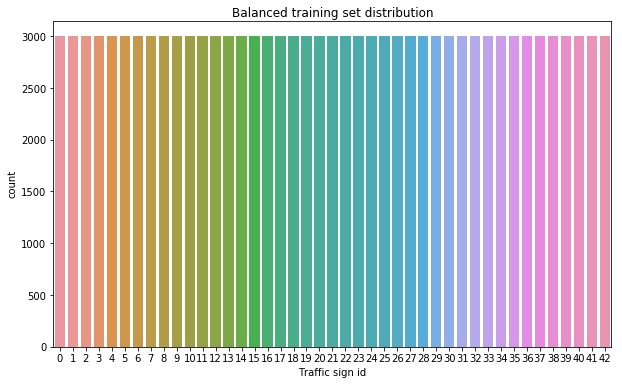

In [14]:
bal_class_id, bal_class_size = np.unique(y_train_bal, return_counts=True)

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_bal)
# plt.bar(bal_class_id, bal_class_size, align='center')
plt.title('Balanced training set distribution')
plt.xlabel('Traffic sign id');

# plt.figure(figsize=(60,30))
# class_id, class_size = np.unique(y_train_bal, return_counts=True)
# plt.bar(class_id,class_size,align='center')
# plt.title('Distribution after augmentation')

#### Check if labels are still correct after data augmentation

In [76]:
def plot_rand(X_data, y_data, pre=False):
    rand_inds = np.random.randint(0,len(X_data),size=(1,6))

    num_rows = 2
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,6))
    fig.subplots_adjust(wspace=2)
    axs = axs.ravel()

    for i in range(num_rows*num_cols):
        if not pre:
            axs[i].imshow(X_data[rand_inds[0][i]])
        if pre:
            axs[i].imshow(X_data[rand_inds[0][i],:,:,0],cmap='gray')
        sign_id = y_data[rand_inds[0][i]]
        axs[i].title.set_text(map_ids[sign_id])

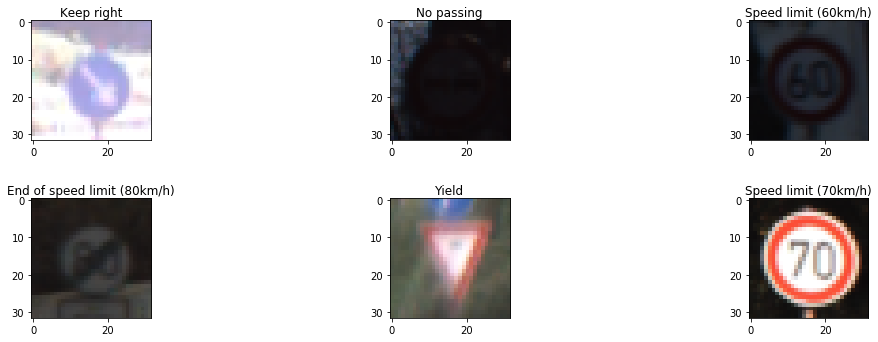

In [77]:
plot_rand(X_train_bal, y_train_bal)

#### Define transformation functions

In [43]:
def translate(image, pixels=2): # value taken from "lecun-paper"
    tx = np.random.randint(-pixels, pixels+1)
    ty = np.random.randint(-pixels, pixels+1)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(image, M, (32, 32))

def scale(image, scale_val=.1): # value taken from "lecun-paper"
    # rotation functions used for scaling
    factor = 1 + (np.random.rand()-.5)*scale_val
    M = cv2.getRotationMatrix2D((16,16),0,factor)
    return cv2.warpAffine(image, M, (32,32))

def rotate(image, angle=15): # angle taken from "lecun-paper"
    angle = np.random.uniform(-angle, angle)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))

# apply all transforms
def transform(image):
    image = translate(image)
    image = scale(image)
    image = rotate(image)
    return image

#### Test transformations

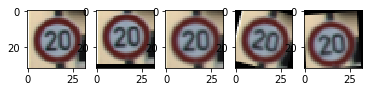

In [46]:
test_img = X_train_bal[0]

transforms = np.zeros((5,32,32,3),dtype=np.uint8)
transforms[0] = test_img
transforms[1] = translate(test_img)
transforms[2] = scale(test_img)
transforms[3] = rotate(test_img)
transforms[4] = transform(test_img)

fig, axs = plt.subplots(1,5)
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(transforms[i])

#### Transform fraction of all test images

In [48]:
from sklearn.utils import shuffle

X_train_aug = np.copy(X_train_bal)
y_train_aug = np.copy(y_train_bal)

trans_perc = 1 # define percentage (0-1) of training images to transform

# shuffle training images
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

for i in range(int(len(X_train_aug)*trans_perc)):
    # replace image by transformed one
    X_train_aug[i] = transform(X_train_aug[i])

#### Bypass transformation if required

In [50]:
# X_train_aug = np.copy(X_train)
# y_train_aug = np.copy(y_train)

#### Plot random images from augmented data set to check if label is correct

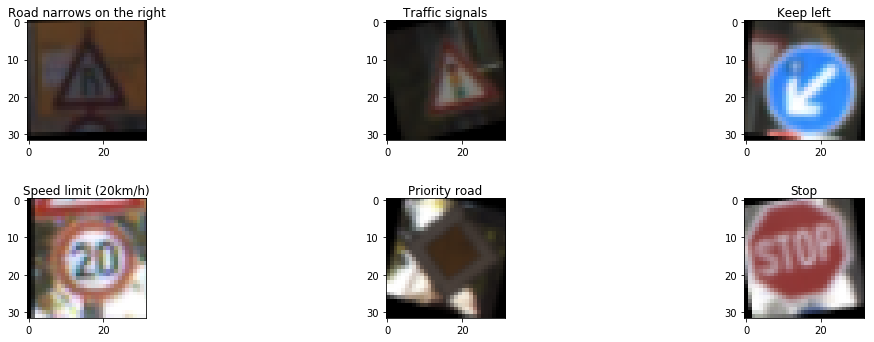

In [78]:
plot_rand(X_train_aug, y_train_aug)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [56]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

Shuffle data to avoid overfitting

In [57]:
from sklearn.utils import shuffle

X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
# X_train_aug, y_train_aug = shuffle(X_train, y_train)

### Grayscale conversion and normalization

Grayscale [OpenCV documentation](https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html)

#### Function definitions

In [119]:
def x2gray(imgs):
    r_ch = imgs[:,:,:,0]
    g_ch = imgs[:,:,:,1]
    b_ch = imgs[:,:,:,2]
    imgs_gray = 0.299*r_ch + 0.587*g_ch + 0.114*b_ch
    return imgs_gray[:,:,:,np.newaxis]

def norm_img(imgs):
    return np.add(imgs, -128)/128

def preprocess(imgs):
    '''Function to preprocess images.
    Input: Color images.
    Output: Normalized grayscale images.'''
    imgs = norm_img(imgs)
    imgs = x2gray(imgs)
    return imgs

#### Function application

In [115]:
X_train_pre = preprocess(X_train_aug)
y_train_pre = np.copy(y_train_aug)

X_valid_pre = preprocess(X_valid)
y_valid_pre = np.copy(y_valid)

X_test_pre = preprocess(X_test)
y_test_pre = np.copy(y_test)

In [116]:
print('Shape before and after grayscale conversion:\n {}, {}\n {}, {}\n {}, {}'
        .format(X_train_aug.shape, X_train_pre.shape, 
             X_valid.shape, X_valid_pre.shape,
             X_test.shape, X_test_pre.shape))

print('Min and max values of preprocessed images:\n {}\n {}\n {}\n'
      .format((np.min(X_train_pre), np.max(X_train_pre)),
             (np.min(X_valid_pre), np.max(X_valid_pre)),
             (np.min(X_test_pre), np.max(X_test_pre))))

Shape before and after grayscale conversion:
 (129000, 32, 32, 3), (129000, 32, 32, 1)
 (4410, 32, 32, 3), (4410, 32, 32, 1)
 (12630, 32, 32, 3), (12630, 32, 32, 1)
Min and max values of preprocessed images:
 (-0.9999999999999999, 0.9921874999999999)
 (-0.9646328125, 0.9921874999999999)
 (-0.9716406249999999, 0.9921874999999999)



#### Bypass preproccessing if required

In [67]:
# X_train_pre = np.copy(X_train_aug)
# X_valid_pre = np.copy(X_valid)
# X_test_pre = np.copy(X_test)

#### Plot some random preprocessed images

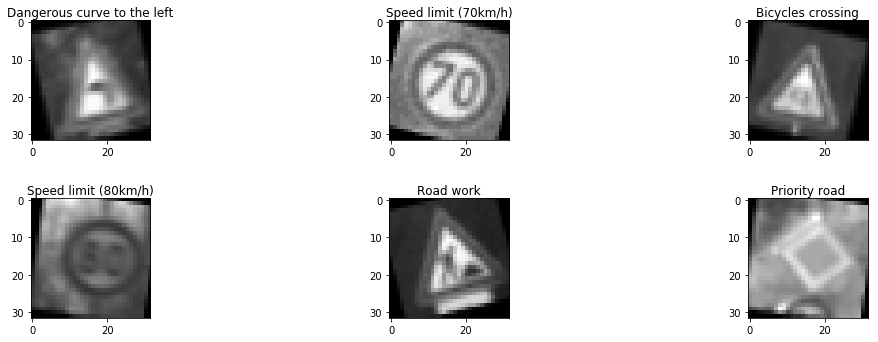

In [79]:
plot_rand(X_train_pre, y_train_pre, pre=True)

## Model Architecture

In [80]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [81]:
# Lesson 13 (12) https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/6b6c37bc-13a5-47c7-88ed-eb1fce9789a0/lessons/0fb1d383-484e-4c49-a0e4-03922c1416d6/concepts/d0db3cab-ad70-46ec-9614-4dfc27dfc865

# In summary TensorFlow uses the following equation for 'SAME' vs 'VALID'

# SAME Padding, the output height and width are computed as:

# out_height = ceil(float(in_height) / float(strides[1]))
# out_width = ceil(float(in_width) / float(strides[2]))

# VALID Padding, the output height and width are computed as:

# out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
# out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))

In [82]:
import numpy as np
in_h = 32
filter_h = 1
stride = 1
# out_h = np.ceil(float(in_h) / float(stride)) # same
out_h = np.ceil(float(in_h - filter_h + 1) / float(stride)) # valid
print(out_h)

32.0


In [83]:
7*7*25

1225

In [84]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    print('shape layer1 before booling (expected: 28x28x6): ',conv1.shape)
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     conv1 = tf.nn.dropout(conv1, rate=.5)
    print('shape layer1 (expected: 14x14x6): ', conv1.shape)
    
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 25), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(25))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print('shape layer2 (expected: 5x5x16): ', conv2.shape)
#     conv2 = tf.nn.dropout(conv2, rate=.5)
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    print('shape layer2, flat (expected: 400): ', fc0.shape)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(625, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=.5)
    print('shape layer3 (expected: 120): ', fc1.shape)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc11_W = tf.Variable(tf.truncated_normal(shape=(400, 256), mean = mu, stddev = sigma))
    fc11_b = tf.Variable(tf.zeros(256))
    fc11   = tf.matmul(fc1, fc11_W) + fc11_b
    # SOLUTION: Activation.
    fc11    = tf.nn.relu(fc11)
    fc11 = tf.nn.dropout(fc11, rate=.5)
    print('shape layer3 (expected: 120): ', fc11.shape)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc11, fc2_W) + fc2_b
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=.5)
    print('shape layer4 (expected: 84): ', fc2.shape)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print('shape layer5 (expected: 43): ', logits.shape)
    
    return logits, conv1, conv2

x and y are placeholders for batches

In [85]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training

In [86]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.test.gpu_device_name()

In [87]:
tf.test.is_built_with_cuda()

True

### Training pipeline

In [90]:
EPOCHS = 200
BATCH_SIZE = 128
rate = 0.001

beta = 0.01

# input is passed to LeNet function to calculate logits
logits, conv1, conv2 = LeNet(x)
# compare logits to ground truth labels and calculate cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# averages cross entropy from all training images
loss_operation = tf.reduce_mean(cross_entropy)

# regularizer = tf.nn.l2_loss(weights)
# loss_operation = tf.reduce_mean(loss_operation + beta*regularizer)

# initialize optimizer (Adam algorithm is similar to but more sofisticated than stochastic gradient descent)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# backprob is used here
training_operation = optimizer.minimize(loss_operation)

W0731 14:16:16.202289 139773955524416 deprecation.py:323] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


shape layer1 before booling (expected: 28x28x6):  (?, 28, 28, 16)
shape layer1 (expected: 14x14x6):  (?, 14, 14, 16)
shape layer2 (expected: 5x5x16):  (?, 5, 5, 25)


W0731 14:16:16.572501 139773955524416 deprecation.py:323] From <ipython-input-90-60e4bc2e3940>:10: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



shape layer2, flat (expected: 400):  (?, 625)
shape layer3 (expected: 120):  (?, 400)
shape layer3 (expected: 120):  (?, 256)
shape layer4 (expected: 84):  (?, 128)
shape layer5 (expected: 43):  (?, 43)


Model Evaluation

In [91]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Model Training

Training...


EPOCH 1 :  train_acc = 0.627 , valid_acc = 0.621 (max)
EPOCH 2 :  train_acc = 0.815 , valid_acc = 0.791 (max)
EPOCH 3 :  train_acc = 0.889 , valid_acc = 0.863 (max)
EPOCH 4 :  train_acc = 0.919 , valid_acc = 0.887 (max)
EPOCH 5 :  train_acc = 0.938 , valid_acc = 0.907 (max)
EPOCH 6 :  train_acc = 0.951 , valid_acc = 0.922 (max)
EPOCH 7 :  train_acc = 0.954 , valid_acc = 0.921 
EPOCH 8 :  train_acc = 0.966 , valid_acc = 0.935 (max)
EPOCH 9 :  train_acc = 0.963 , valid_acc = 0.932 
EPOCH 10 :  train_acc = 0.967 , valid_acc = 0.946 (max)
EPOCH 11 :  train_acc = 0.967 , valid_acc = 0.939 
EPOCH 12 :  train_acc = 0.975 , valid_acc = 0.953 (max)
EPOCH 13 :  train_acc = 0.976 , valid_acc = 0.945 
EPOCH 14 :  train_acc = 0.981 , valid_acc = 0.954 (max)
EPOCH 15 :  train_acc = 0.979 , valid_acc = 0.952 
EPOCH 16 :  train_acc = 0.979 , valid_acc = 0.958 (max)
EPOCH 17 :  train_acc = 0.972 , valid_acc = 0.943 
EPOCH 18 :  train_acc = 0.980 , valid_acc = 0.950 
EPOCH 19 :  train_acc 

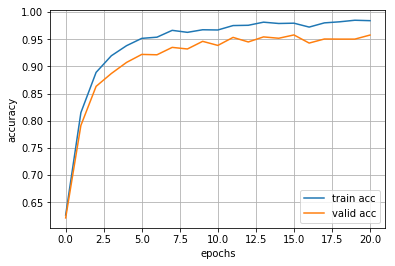

In [92]:
from tqdm import tqdm
import time

try:
    saver
except NameError:
    saver = tf.train.Saver()

max_acc = 0
max_acc_epoch = 0

# start time measurement
time_start = time.time()

acc_df = pd.DataFrame({'epoch': [], 'train acc': [], 'valid acc': []})
# accuracy_course = np.zeros(2,EPOCHS)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pre)

    print("Training...")
    print()
    
    for i in range(EPOCHS):
        
        X_train_pre, y_train_aug = shuffle(X_train_pre, y_train_aug)
#         for offset in tqdm(range(0, num_examples, BATCH_SIZE)): # includes tqdm progess meter
        for offset in range(0, num_examples, BATCH_SIZE): #without tqdm progress meter     
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_pre[offset:end], y_train_aug[offset:end]
            # training
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                
        train_accuracy = evaluate(X_train_pre, y_train_aug)
        #         accuracy_course[0,i] = train_accuracy
        valid_accuracy = evaluate(X_valid_pre, y_valid)
        #         accuracy_course[1,i] = valid_accuracy

        print("\nEPOCH {}".format(i+1), ": ", 
              "train_acc = {:.3f}".format(train_accuracy), ", "
              "valid_acc = {:.3f}".format(valid_accuracy),end=" ")

        acc_df = acc_df.append({'epoch': i, 
                       'train acc': train_accuracy, 'valid acc': valid_accuracy}, 
                      ignore_index=True)
        
        if valid_accuracy > max_acc:
            max_acc_epoch, max_acc = i, valid_accuracy
            saver.save(sess, './lenet.ckpt')
            print('(max)',end="")
        elif i - max_acc_epoch >= 5:
            print('Stopping after 5 epochs without improvement.')
            break
        
#     try:
#         saver
#     except NameError:
#         saver = tf.train.Saver()
#     saver.save(sess, './lenet')
#     print("Model saved")

    acc_df['training accuracy'].plot(legend=True)
    ax = acc_df['validation accuracy'].plot(grid=True,legend=True)
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy');
    
# stop time measurement and print result
time_end = time.time()
print('Training time: ', np.round(time_end-time_start,2), 's')

In [ ]:
#stop here

In [93]:
# run this cell only once!

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_pre, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

W0731 14:23:15.561098 139773955524416 deprecation.py:323] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test Accuracy = 0.931


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [94]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Read, preprocess and plot the new images

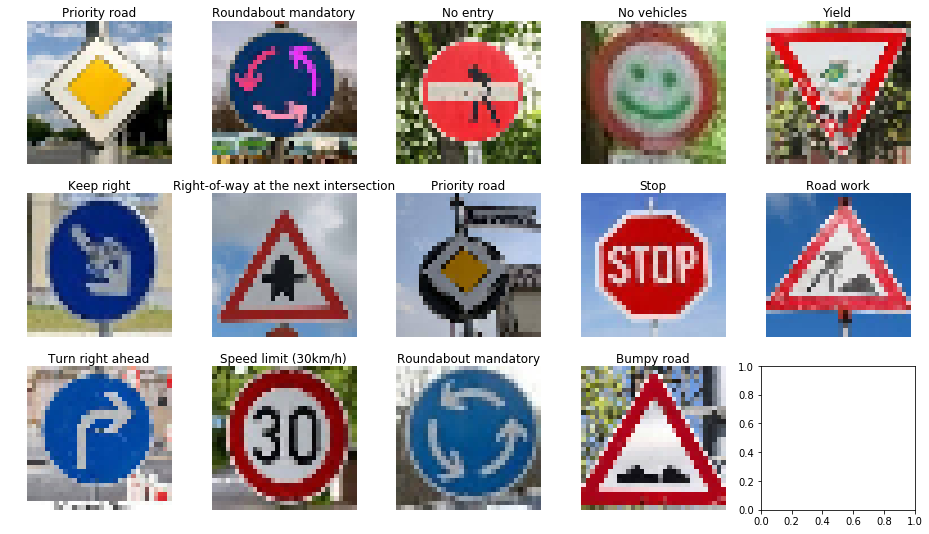

In [170]:
X_new_test = []
path = './traffic_sign_images/'

img_names = sorted(os.listdir(path))
n_imgs = len(img_names)


X_test_new = np.zeros([len(img_names), 32, 32, 3], dtype=np.uint8)
y_test_new = np.array([12, 40, 17, 15, 13, 38, 11, 12, 14, 25, 33,  1, 40, 22])

fig, axs = plt.subplots(3,5,figsize=(16,9))
axs = axs.ravel()

for idx, img_name in enumerate(img_names):
    img = cv2.cvtColor(cv2.imread(path+img_name), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32))
    X_test_new[idx] = img
    # plots:
    axs[idx].imshow(X_test_new[idx])
    axs[idx].set_title(map_ids[y_test_new[idx]])
    axs[idx].axis('off')

# preprocess all images
X_test_new_pre = preprocess(X_test_new)
y_test_new_pre = np.copy(y_test_new)

### Predict the Sign Type for Each Image

In [171]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [172]:

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
#     saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_pred_new = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_new_pre, y: y_test_new_pre})
    print('Numbers:      ', np.arange(1,n_imgs+1))
    print('----------------------------------------------------------')
    print('Prediction:   ', y_pred_new)
    print('Ground truth: ', y_test_new)

Numbers:       [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
----------------------------------------------------------
Prediction:    [12 40 17  8 13 38 11 12 14 25 33  1 40 22]
Ground truth:  [12 40 17 15 13 38 11 12 14 25 33  1 40 22]


### Analyze Performance

In [173]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [174]:
with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        saver.restore(sess, './lenet.ckpt')
        new_test_accuracy = evaluate(X_test_new_pre, y_test_new_pre)
        print("Test Accuracy (new images) = {:.3f}".format(new_test_accuracy))

Test Accuracy (new images) = 0.929


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [175]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

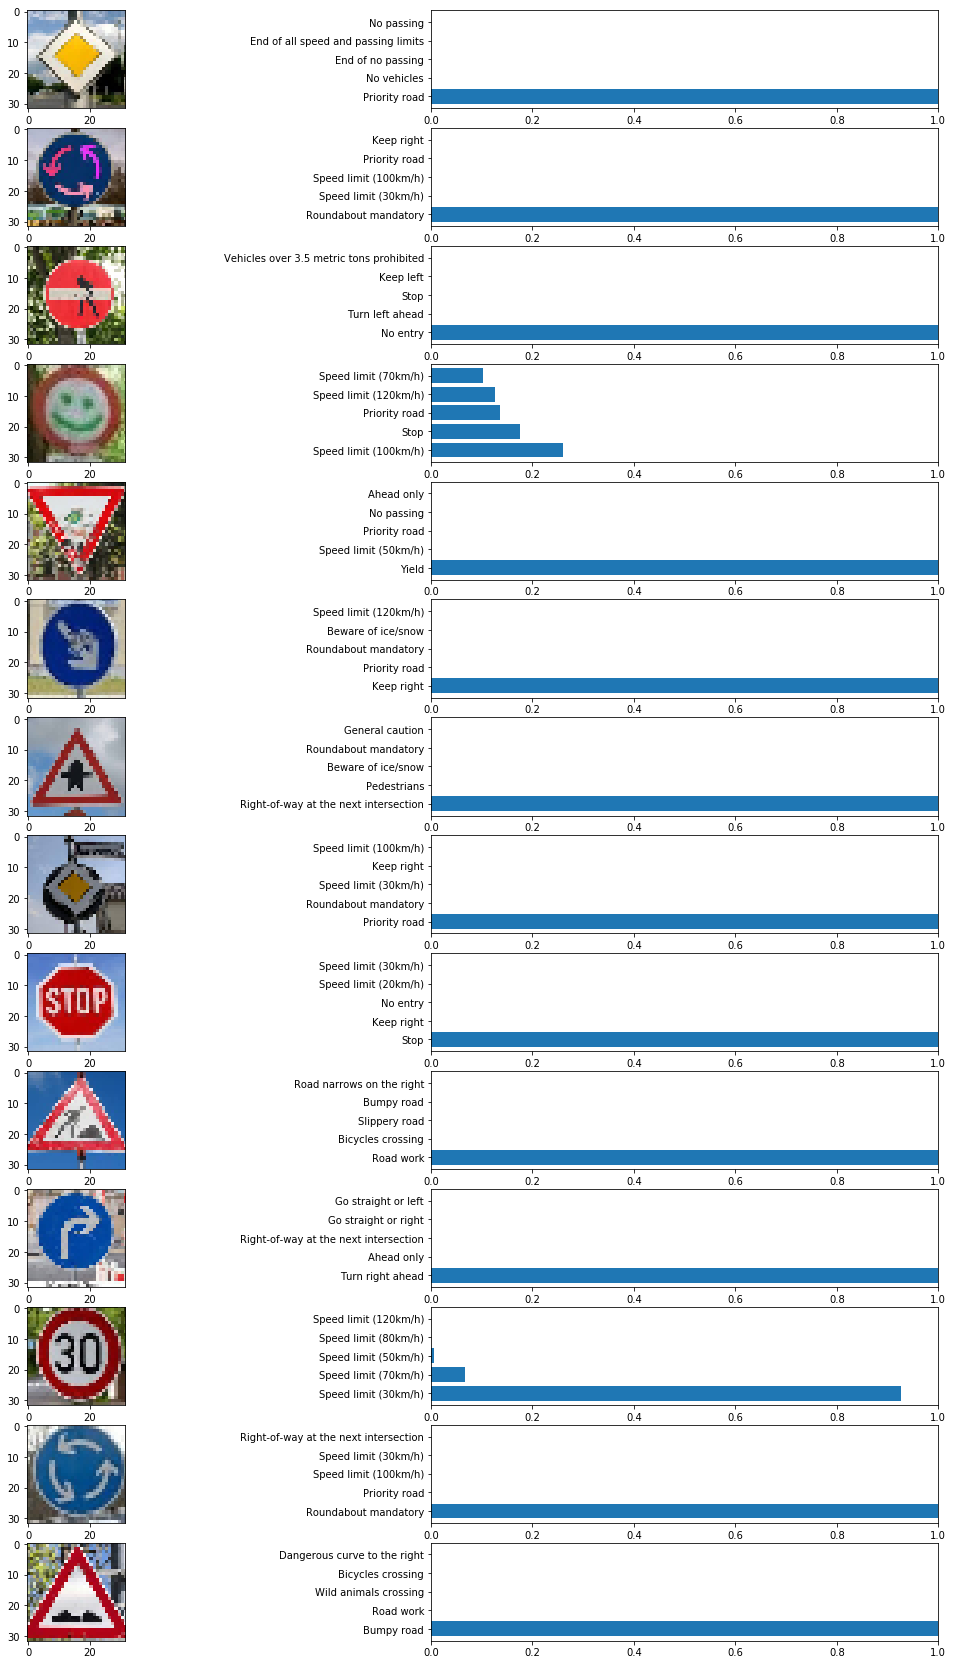

In [176]:
with tf.Session() as sess:
#         saver = tf.train.Saver()
    saver.restore(sess, './lenet.ckpt')
    y_prob_new, y_pred_new = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), 
                                      feed_dict={x: X_test_new_pre, y: y_test_new_pre})

fig, axs = plt.subplots(n_imgs, 2, figsize=(20,30))
axs = np.ravel(axs)

for i in range(n_imgs):
    axs[2*i].imshow(X_test_new[i])
    axs[2*i+1].barh(np.arange(len(y_prob_new[0])), y_prob_new[i], align='center')
    pred_labels = [map_ids[j] for j in y_pred_new[i]]
    axs[2*i+1].set_xlim([0,1])
    axs[2*i+1].set_yticks(np.arange(0,len(pred_labels),1))
    axs[2*i+1].set_yticklabels(pred_labels)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [177]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# Note: that to get access to tf_activation, the session should be interactive which can be achieved with the following commands.
# sess = tf.InteractiveSession()
# sess.as_default()

# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and    max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

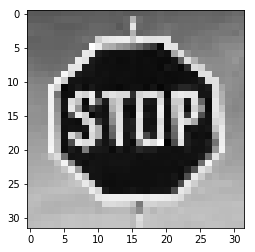

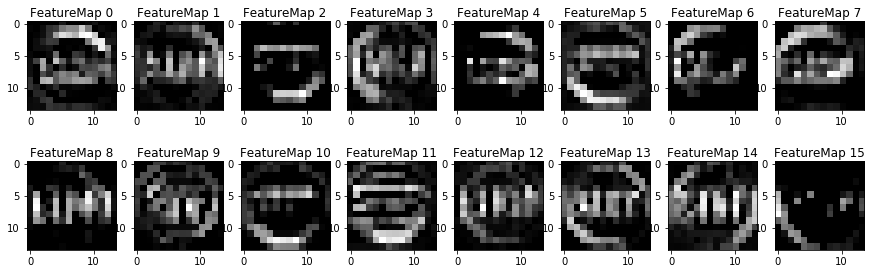

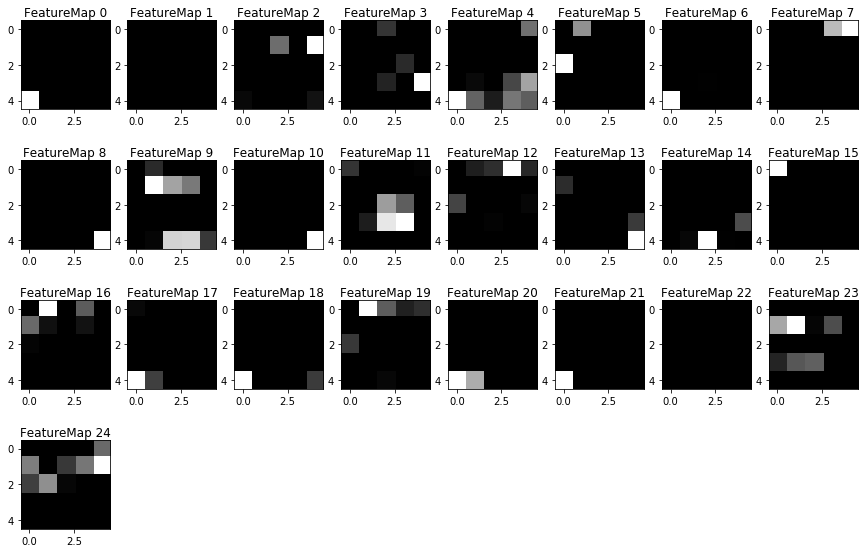

In [178]:
with tf.Session() as sess:    
    saver.restore(sess, './lenet.ckpt')
    
    img_idx = 8
    plt.imshow(X_test_new_pre[img_idx,:,:,0], cmap='gray')
    plt.show()
    outputFeatureMap(X_test_new_pre[img_idx].reshape(1,32,32,1), conv1, plt_num=1)
    outputFeatureMap(X_test_new_pre[img_idx].reshape(1,32,32,1), conv2, plt_num=2)
    